In [5]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [31]:
from helpers import load_data

# load dataset
x, y = load_data()

In [32]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [33]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    indice_te = k_indices[k]
    indice_tr = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    indice_tr = indice_tr.reshape(-1)
    x_tr = x[indice_tr]
    x_te = x[indice_te]
    y_tr = y[indice_tr]
    y_te = y[indice_te]
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form data with polynomial degree: TODO
    poly_tx_tr = build_poly(x_tr, degree)
    poly_tx_te = build_poly(x_te, degree)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    w = ridge_regression(y_tr, poly_tx_tr, lambda_)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    # Calculate loss of cost function root mse (RMSE)
    loss_tr = np.sqrt(2 * compute_mse(y_tr, poly_tx_tr, w))
    loss_te = np.sqrt(2 * compute_mse(y_te, poly_tx_te, w))
    
    return loss_tr, loss_te, w

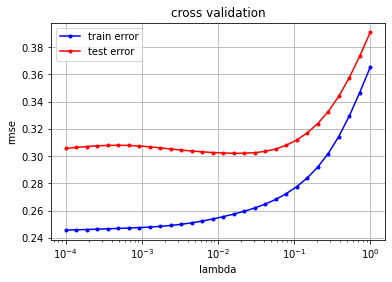

In [34]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 12
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    for lambda_ in lambdas:
        rmse_tr_lambda_ = []
        rmse_te_lambda_ = []
        
        for k in range(k_fold):
            loss_tr, loss_te, w = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_lambda_.append(loss_tr)
            rmse_te_lambda_.append(loss_te)
        
        # Calculate mean loss and save results to list
        rmse_tr.append(np.mean(rmse_tr_lambda_))
        rmse_te.append(np.mean(rmse_te_lambda_))
    
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

In [35]:
def select_best_degree(degrees, k_fold, lambdas, seed=1):
    # Split the data into k-fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    # Set lists for collecting best lambda & rmse for each degree
    best_lambda = []
    best_rmse = []
    
    for degree in degrees:
        rmse_te = []
        for lambda_ in lambdas:
            rmse_te_lambda_ = []
            for k in range(k_fold):
                _, loss_te, _ = cross_validation(y, x, k_indices, k, lambda_, degree)
                rmse_te_lambda_.append(loss_te)
            rmse_te.append(np.mean(rmse_te_lambda_))
        index_opt_lambda = np.argmin(rmse_te)
        best_lambda.append(lambdas[index_opt_lambda])
        best_rmse.append(rmse_te[index_opt_lambda])
        # print(best_rmse)
    
    opt_degree = degrees[np.argmin(best_rmse)]
    
    return opt_degree


In [36]:
select_best_degree(np.arange(2,11), 4, np.logspace(-4, 0, 30))

8

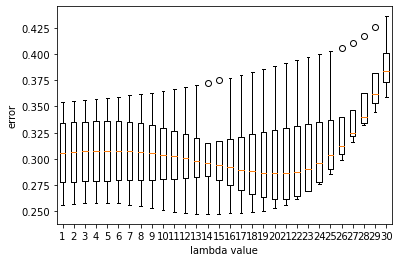

In [37]:
def cross_validation_boxplot_demo():
    seed = 12
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    variance = []
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    for lambda_ in lambdas:
        rmse_tr_lambda_ = []
        rmse_te_lambda_ = []
        
        for k in range(k_fold):
            loss_tr, loss_te, w = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_lambda_.append(loss_tr)
            rmse_te_lambda_.append(loss_te)
        
        # Calculate mean loss and save results to list
        rmse_tr.append(rmse_tr_lambda_)
        rmse_te.append(rmse_te_lambda_)
        
    plt.boxplot(rmse_te)
    plt.xlabel('lambda value')
    plt.ylabel('error')

cross_validation_boxplot_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

/home/philipliu/Documents/CS433/ML_course-master/labs/ex04/template/plots.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  linewidth=0.3)
/home/philipliu/Documents/CS433/ML_course-master/labs/ex04/template/plots.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  linewidth=0.3)


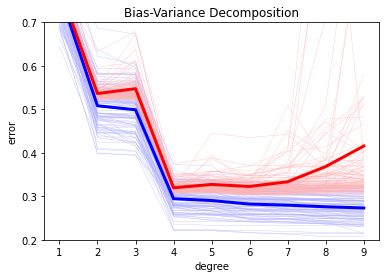

In [38]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # INSERT YOUR CODE HERE
        # split data with a specific seed: TODO
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # bias_variance_decomposition: TODO
        for index_degree, degree in enumerate(degrees):
            poly_tx_tr = build_poly(x_tr, degree)
            poly_tx_te = build_poly(x_te, degree)
            w, _ = least_squares(y_tr, poly_tx_tr)
            
            # Collect rmse for each combination of seed and degree (both training set and test set)
            rmse_tr[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_tr, poly_tx_tr, w))
            rmse_te[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_te, poly_tx_te, w))     

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()

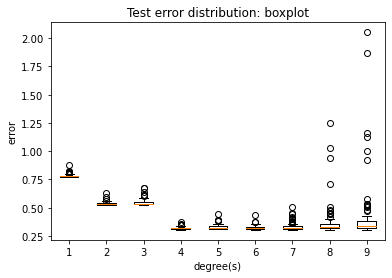

In [39]:
def test_error_boxplot_demo():
    # Define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # Define lists to store the variables of rmse for test set
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        # Split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        for index_degree, degree in enumerate(degrees):
            # Form polynomial extension data
            poly_tx_tr = build_poly(x_tr, degree)
            poly_tx_te = build_poly(x_te, degree)
            
            # Calculate w* by least squares
            w, _ = least_squares(y_tr, poly_tx_tr)
            
            # Calculate rmse on test set
            rmse_te[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_te, poly_tx_te, w))
            
    plt.boxplot(rmse_te)
    plt.xlabel('degree(s)')
    plt.ylabel('error')
    plt.title('Test error distribution: boxplot')
        
test_error_boxplot_demo()

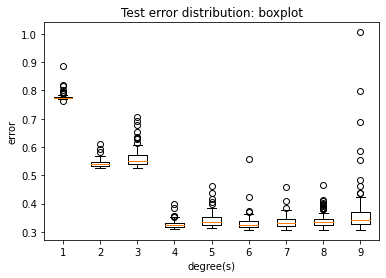

In [52]:
def test_error_boxplot_ridge():
    # Define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    lambdas = np.logspace(-4, 0, 30)
    
    # Define lists to store the variables of rmse for test set
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        # Split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        # Define K-fold parameters and generate k-fold indices
        k_fold = 4
        k_indices = build_k_indices(y_tr, k_fold, 1)
    
        for index_degree, degree in enumerate(degrees):
            # Form polynomial extension of test data
            poly_tx_te = build_poly(x_te, degree)
            
            rmse_te_degree = []
            ws_degree = []
        
            for lambda_ in lambdas:
                rmse_te_lambda_ = []
                ws_lambda_ = []
                
                for k in range(k_fold):
                    _, loss_te, w = cross_validation(y_tr, x_tr, k_indices, k, lambda_, degree)
                    rmse_te_lambda_.append(loss_te)
                    ws_lambda_.append(w)
                
                rmse_te_degree.append(np.mean(rmse_te_lambda_))
                ws_degree.append(ws_lambda_)
            
            index_opt_lambda = np.argmin(rmse_te_degree)
            ws_opt = ws_degree[index_opt_lambda]
            rmse_opt = rmse_te_degree[index_opt_lambda]
            
            # Calculate the rmse for test set
            rmse_te[index_seed, index_degree] = np.mean([np.sqrt(2 * compute_mse(y_te, poly_tx_te, w))
                                                         for w in ws_opt])
    
    plt.boxplot(rmse_te)
    plt.xlabel('degree(s)')
    plt.ylabel('error')
    plt.title('Test error distribution: boxplot')
    
test_error_boxplot_ridge()